# Statistical Validation & Analysis

**Objective**: Validate models and perform statistical hypothesis testing

## Goals:
1. Validate clustering quality with multiple metrics
2. Analyze score distributions by various factors
3. Perform correlation analysis
4. Conduct hypothesis testing
5. Feature importance analysis
6. Generate insights and findings

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu, kruskal, chi2_contingency
from sklearn.metrics import silhouette_samples
import joblib

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Scored Data

In [19]:
# Load data with scores and clusters
df = pd.read_csv('../data/processed/resumes_scored.csv')

print(f"✓ Loaded data: {df.shape}")
print(f"  Records: {len(df)}")
print(f"  Features: {len(df.columns)}")

# Summary statistics
print(f"\nScore Statistics:")
print(df[['Final_Score', 'Percentile_Overall']].describe())

df.head()

✓ Loaded data: (495, 71)
  Records: 495
  Features: 71

Score Statistics:
       Final_Score  Percentile_Overall
count   495.000000          495.000000
mean     30.826024           50.101010
std      19.366000           28.896186
min      -2.284159            0.202020
25%      16.426285           25.151515
50%      29.107163           50.303030
75%      42.858840           75.050505
max      86.312884          100.000000


,ID,Category,Resume,Experience_Years,Education_Level,Skills,Num_Skills,Has_Certification,Num_Companies,Resume_str,...,TSNE2,Score_Skills,Score_Experience,Score_Education,Score_Certification,Score_Leadership,Final_Score,Percentile_Overall,Percentile_Category,Percentile_Band
0,SYN_0001,Web Development,Full Stack Developer with 3 years of experienc...,-0.491615,Bachelor's,"Node.js, CSS, JavaScript, Redux, Vue.js, Expre...",0.192366,False,-0.627279,Unknown,...,2.206011,-11.871786,35.083854,70,0,0,19.776442,33.131313,1.923077,Below Average
1,SYN_0002,Web Development,Full Stack Developer with 9 years of experienc...,1.870999,Bachelor's,"Node.js, REST APIs, MySQL, Vue.js, PostgreSQL,...",1.445273,False,2.624062,Unknown,...,5.988521,52.859426,58.709992,70,0,100,57.756768,88.282828,63.461538,Top 25%
2,SYN_0003,Software Engineering,Software Engineer with 6 years of experience. ...,0.689692,Master's,"Go, Programming, SQL, JavaScript, Algorithms, ...",0.505593,False,0.998392,Unknown,...,-7.620644,50.980064,46.896923,85,0,100,56.461103,87.878788,74.545455,Top 25%
3,SYN_0004,Web Development,Full Stack Developer with 5 years of experienc...,0.295923,Master's,"Node.js, CSS, Angular, JavaScript, MySQL, Vue....",1.132046,True,-0.627279,Unknown,...,5.066784,83.345670,42.959233,85,100,100,73.226038,97.575758,92.307692,Top 10%
4,SYN_0005,Network Engineering,Network Engineer with 2 years of experience. S...,-0.885384,Bachelor's,"Networking, Load Balancer, TCP/IP, Security, W...",-1.373769,False,-0.627279,Unknown,...,10.803934,-46.116754,31.146165,70,0,0,4.897148,6.464646,16.666667,Bottom 25%


## 2. Clustering Validation - Deep Dive

In [20]:
# Silhouette analysis per sample
print("Silhouette Analysis:")
print("="*60)

# Load clustering features
import json
with open('../models/clustering_features.json', 'r') as f:
    clustering_features = json.load(f)

# Filter to existing features
clustering_features = [f for f in clustering_features if f in df.columns]

# Prepare X
X = df[clustering_features].fillna(df[clustering_features].median())

# Calculate silhouette scores per sample
if 'Cluster_KMeans' in df.columns:
    silhouette_vals = silhouette_samples(X, df['Cluster_KMeans'])
    df['Silhouette_Score'] = silhouette_vals
    
    print(f"\nOverall Silhouette Score: {silhouette_vals.mean():.3f}")
    print(f"\nSilhouette Score by Cluster:")
    for cluster in sorted(df['Cluster_KMeans'].unique()):
        cluster_silhouette = silhouette_vals[df['Cluster_KMeans'] == cluster].mean()
        print(f"  Cluster {cluster}: {cluster_silhouette:.3f}")

Silhouette Analysis:

Overall Silhouette Score: 0.331

Silhouette Score by Cluster:
  Cluster 0: 0.327
  Cluster 1: 0.291
  Cluster 2: 0.383
  Cluster 3: 0.324
  Cluster 4: 0.418
  Cluster 5: 0.322
  Cluster 6: 0.301
  Cluster 7: 0.569


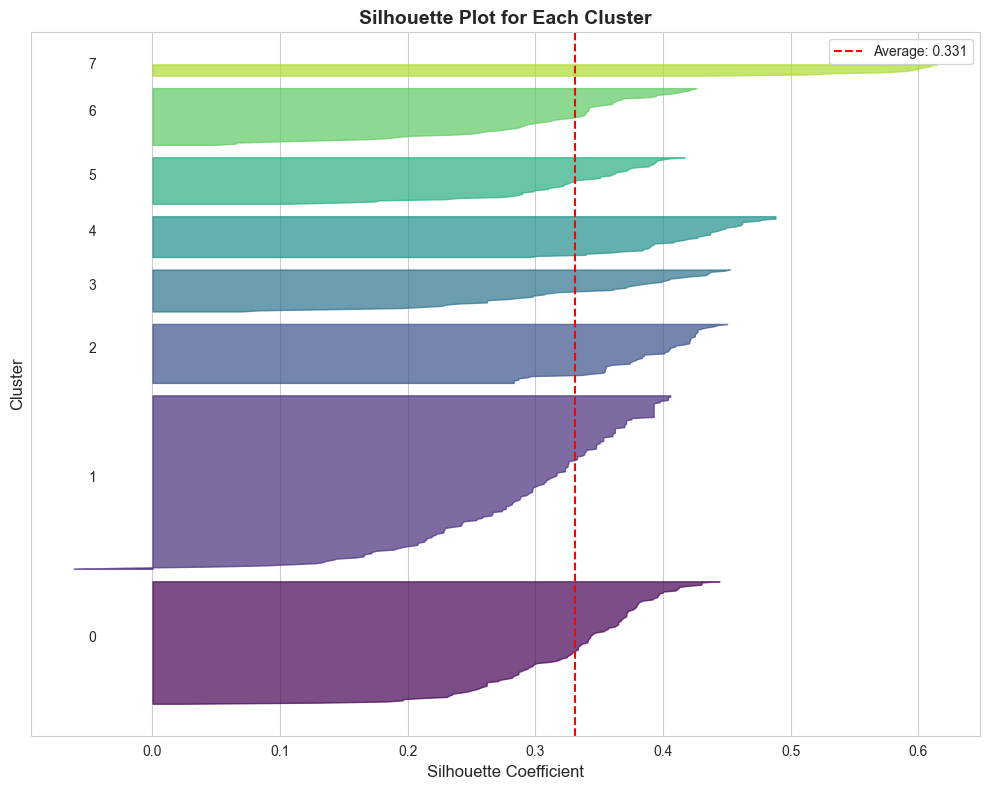


📊 Interpretation:
  - Positive values: samples well-matched to their clusters
  - Negative values: samples might be in wrong cluster
  - Thicker plots: larger clusters


In [21]:
# Silhouette plot
if 'Cluster_KMeans' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    y_lower = 10
    for cluster in sorted(df['Cluster_KMeans'].unique()):
        # Get silhouette values for this cluster
        cluster_silhouette_vals = silhouette_vals[df['Cluster_KMeans'] == cluster]
        cluster_silhouette_vals.sort()
        
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        
        color = plt.cm.viridis(cluster / df['Cluster_KMeans'].nunique())
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        
        y_lower = y_upper + 10
    
    ax.set_xlabel('Silhouette Coefficient', fontsize=12)
    ax.set_ylabel('Cluster', fontsize=12)
    ax.set_title('Silhouette Plot for Each Cluster', fontsize=14, fontweight='bold')
    ax.axvline(x=silhouette_vals.mean(), color="red", linestyle="--", 
               label=f'Average: {silhouette_vals.mean():.3f}')
    ax.legend()
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Interpretation:")
    print("  - Positive values: samples well-matched to their clusters")
    print("  - Negative values: samples might be in wrong cluster")
    print("  - Thicker plots: larger clusters")

In [22]:
# Cluster stability analysis
print("\nCluster Stability Analysis:")
print("="*60)

if 'Cluster_KMeans' in df.columns and 'Cluster_Hierarchical' in df.columns:
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    
    ari = adjusted_rand_score(df['Cluster_KMeans'], df['Cluster_Hierarchical'])
    nmi = normalized_mutual_info_score(df['Cluster_KMeans'], df['Cluster_Hierarchical'])
    
    print(f"Adjusted Rand Index: {ari:.3f}")
    print(f"Normalized Mutual Information: {nmi:.3f}")
    
    if ari > 0.7:
        print("\n✅ Strong agreement between clustering methods")
    elif ari > 0.4:
        print("\n✓ Moderate agreement between clustering methods")
    else:
        print("\n⚠️ Low agreement - clusters may not be stable")


Cluster Stability Analysis:
Adjusted Rand Index: 0.810
Normalized Mutual Information: 0.907

✅ Strong agreement between clustering methods


## 3. Score Distribution Analysis

Normality Tests:

Shapiro-Wilk Test (Final Score):
  Statistic: 0.9664
  P-value: 0.0000
  ✗ Scores are not normally distributed


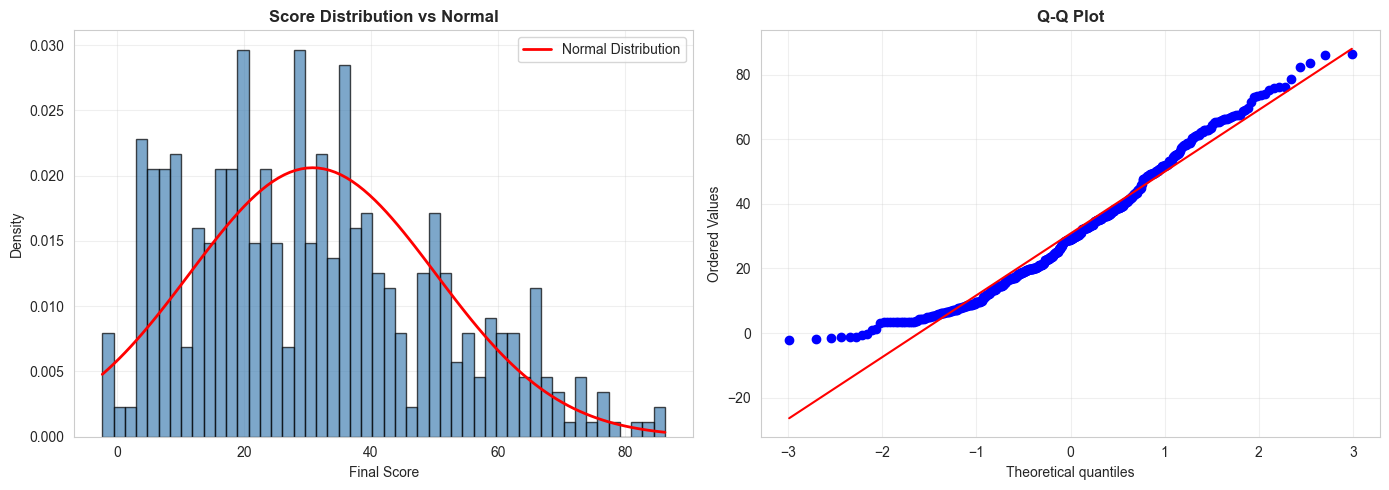

In [23]:
# Test for normality
print("Normality Tests:")
print("="*60)

# Shapiro-Wilk test
stat, p_value = stats.shapiro(df['Final_Score'].sample(min(5000, len(df))))
print(f"\nShapiro-Wilk Test (Final Score):")
print(f"  Statistic: {stat:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value > 0.05:
    print("  ✓ Scores appear normally distributed")
else:
    print("  ✗ Scores are not normally distributed")

# Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with normal curve
mu = df['Final_Score'].mean()
sigma = df['Final_Score'].std()
axes[0].hist(df['Final_Score'], bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
x = np.linspace(df['Final_Score'].min(), df['Final_Score'].max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
axes[0].set_xlabel('Final Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Score Distribution vs Normal', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(df['Final_Score'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Score Distribution by Cluster:
                     mean        std     median        min        max
Cluster_KMeans                                                       
0               31.788390  13.881428  30.002832  -1.532414  67.174470
1               18.219523  12.845178  16.551576  -2.284159  52.380963
2               20.142782  12.610365  19.669785  -0.601689  51.879800
3               44.195647  11.635602  44.874786  21.093972  65.506186
4               18.629179  12.037124  16.877609  -1.281833  42.033729
5               54.361132  16.738148  51.574784  28.856581  86.312884
6               50.787173  15.287407  50.418345  19.776442  78.703010
7               61.685980   7.531272  61.461103  49.416019  73.268796


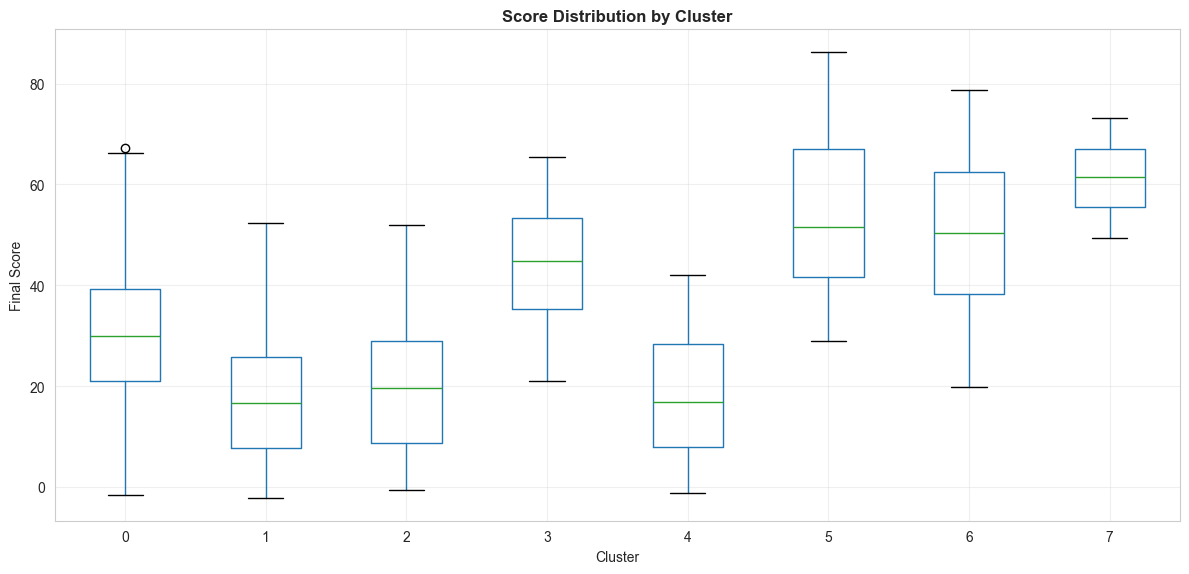

In [24]:
# Score distribution by cluster
if 'Cluster_KMeans' in df.columns:
    print("\nScore Distribution by Cluster:")
    print("="*60)
    
    cluster_scores = df.groupby('Cluster_KMeans')['Final_Score'].agg(['mean', 'std', 'median', 'min', 'max'])
    print(cluster_scores)
    
    # Box plots
    plt.figure(figsize=(12, 6))
    df.boxplot(column='Final_Score', by='Cluster_KMeans', ax=plt.gca())
    plt.xlabel('Cluster')
    plt.ylabel('Final Score')
    plt.title('Score Distribution by Cluster', fontweight='bold')
    plt.suptitle('')  # Remove default title
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Score Distribution by Education Level:
                                mean        std  count
Education_Level                                       
Master's                   35.321833  19.063491    201
Bachelor's                 27.959316  18.923119    237
PhD in Computer Science's  26.891849  19.450898     57


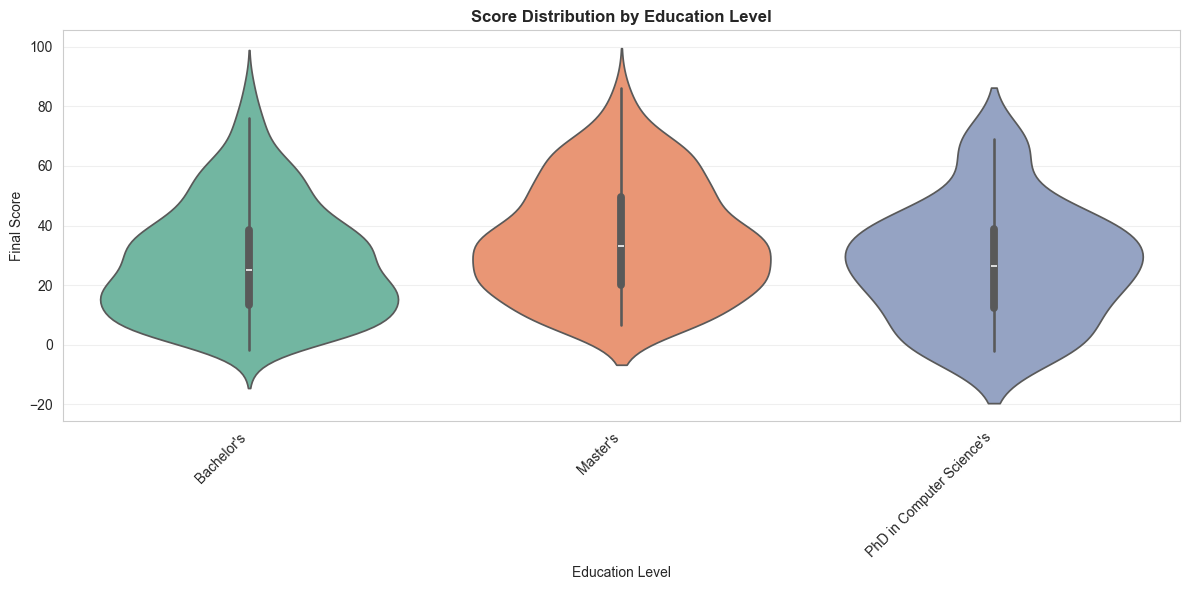

In [25]:
# Score distribution by education level
if 'Education_Level' in df.columns:
    print("\nScore Distribution by Education Level:")
    print("="*60)
    
    edu_scores = df.groupby('Education_Level')['Final_Score'].agg(['mean', 'std', 'count'])
    edu_scores = edu_scores.sort_values('mean', ascending=False)
    print(edu_scores)
    
    # Violin plots
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x='Education_Level', y='Final_Score', palette='Set2')
    plt.xlabel('Education Level')
    plt.ylabel('Final Score')
    plt.title('Score Distribution by Education Level', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

## 4. Hypothesis Testing

Test various hypotheses about the data

In [26]:
print("Hypothesis Testing:")
print("="*80)

# H1: Do candidates with Master's/PhD score significantly higher than Bachelor's?
if 'Education_Level' in df.columns:
    print("\nH1: Master's/PhD candidates score higher than Bachelor's candidates")
    print("-" * 80)
    
    higher_edu = df[df['Education_Level'].isin(["Master's", 'PhD'])]['Final_Score']
    bachelor_edu = df[df['Education_Level'] == "Bachelor's"]['Final_Score']
    
    if len(higher_edu) > 0 and len(bachelor_edu) > 0:
        # T-test
        t_stat, p_value = ttest_ind(higher_edu, bachelor_edu)
        
        print(f"Master's/PhD mean score: {higher_edu.mean():.2f}")
        print(f"Bachelor's mean score: {bachelor_edu.mean():.2f}")
        print(f"Difference: {higher_edu.mean() - bachelor_edu.mean():.2f}")
        print(f"\nT-test results:")
        print(f"  T-statistic: {t_stat:.4f}")
        print(f"  P-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"  ✅ SIGNIFICANT: Higher education candidates score significantly higher (p < 0.05)")
        else:
            print(f"  ✗ NOT SIGNIFICANT: No significant difference (p >= 0.05)")

Hypothesis Testing:

H1: Master's/PhD candidates score higher than Bachelor's candidates
--------------------------------------------------------------------------------
Master's/PhD mean score: 35.32
Bachelor's mean score: 27.96
Difference: 7.36

T-test results:
  T-statistic: 4.0438
  P-value: 0.0001
  ✅ SIGNIFICANT: Higher education candidates score significantly higher (p < 0.05)


In [27]:
# H2: Do candidates with certifications score higher?
if 'Has_Certification' in df.columns or 'Has_Certification_Encoded' in df.columns:
    print("\nH2: Certified candidates score higher than non-certified")
    print("-" * 80)
    
    cert_col = 'Has_Certification' if 'Has_Certification' in df.columns else 'Has_Certification_Encoded'
    
    certified = df[df[cert_col] == 1]['Final_Score']
    not_certified = df[df[cert_col] == 0]['Final_Score']
    
    if len(certified) > 0 and len(not_certified) > 0:
        t_stat, p_value = ttest_ind(certified, not_certified)
        
        print(f"Certified mean score: {certified.mean():.2f}")
        print(f"Not certified mean score: {not_certified.mean():.2f}")
        print(f"Difference: {certified.mean() - not_certified.mean():.2f}")
        print(f"\nT-test results:")
        print(f"  T-statistic: {t_stat:.4f}")
        print(f"  P-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"  ✅ SIGNIFICANT: Certified candidates score significantly higher (p < 0.05)")
        else:
            print(f"  ✗ NOT SIGNIFICANT: No significant difference (p >= 0.05)")


H2: Certified candidates score higher than non-certified
--------------------------------------------------------------------------------
Certified mean score: 40.26
Not certified mean score: 23.88
Difference: 16.38

T-test results:
  T-statistic: 10.2280
  P-value: 0.0000
  ✅ SIGNIFICANT: Certified candidates score significantly higher (p < 0.05)


In [28]:
# H3: Are there significant differences in scores across clusters?
if 'Cluster_KMeans' in df.columns:
    print("\nH3: Scores differ significantly across clusters")
    print("-" * 80)
    
    # Prepare data for ANOVA
    cluster_groups = [df[df['Cluster_KMeans'] == c]['Final_Score'].values 
                     for c in sorted(df['Cluster_KMeans'].unique())]
    
    # One-way ANOVA
    f_stat, p_value = f_oneway(*cluster_groups)
    
    print(f"ANOVA results:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"  ✅ SIGNIFICANT: Clusters have significantly different scores (p < 0.05)")
        print(f"  This validates that clustering creates meaningful groups!")
    else:
        print(f"  ✗ NOT SIGNIFICANT: Clusters don't differ significantly (p >= 0.05)")


H3: Scores differ significantly across clusters
--------------------------------------------------------------------------------
ANOVA results:
  F-statistic: 76.4204
  P-value: 0.0000
  ✅ SIGNIFICANT: Clusters have significantly different scores (p < 0.05)
  This validates that clustering creates meaningful groups!



H4: Skill diversity correlates with scores
--------------------------------------------------------------------------------
Pearson correlation: 0.9292
P-value: 0.0000
  ✅ SIGNIFICANT POSITIVE: Higher diversity → Higher scores (p < 0.05)


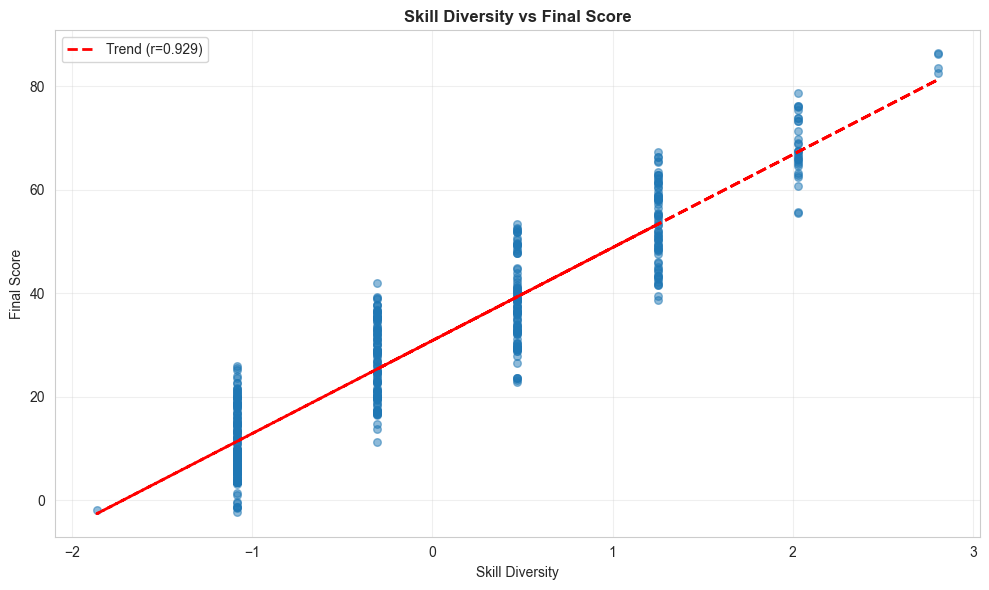

In [29]:
# H4: Does skill diversity correlate with higher scores?
if 'Skill_Diversity' in df.columns:
    print("\nH4: Skill diversity correlates with scores")
    print("-" * 80)
    
    correlation, p_value = stats.pearsonr(df['Skill_Diversity'], df['Final_Score'])
    
    print(f"Pearson correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        if correlation > 0:
            print(f"  ✅ SIGNIFICANT POSITIVE: Higher diversity → Higher scores (p < 0.05)")
        else:
            print(f"  ✅ SIGNIFICANT NEGATIVE: Higher diversity → Lower scores (p < 0.05)")
    else:
        print(f"  ✗ NOT SIGNIFICANT: No correlation (p >= 0.05)")
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Skill_Diversity'], df['Final_Score'], alpha=0.5, s=30)
    
    # Add trend line
    z = np.polyfit(df['Skill_Diversity'], df['Final_Score'], 1)
    p = np.poly1d(z)
    plt.plot(df['Skill_Diversity'], p(df['Skill_Diversity']), "r--", linewidth=2, 
             label=f'Trend (r={correlation:.3f})')
    
    plt.xlabel('Skill Diversity')
    plt.ylabel('Final Score')
    plt.title('Skill Diversity vs Final Score', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Correlation Analysis

Correlation Analysis:


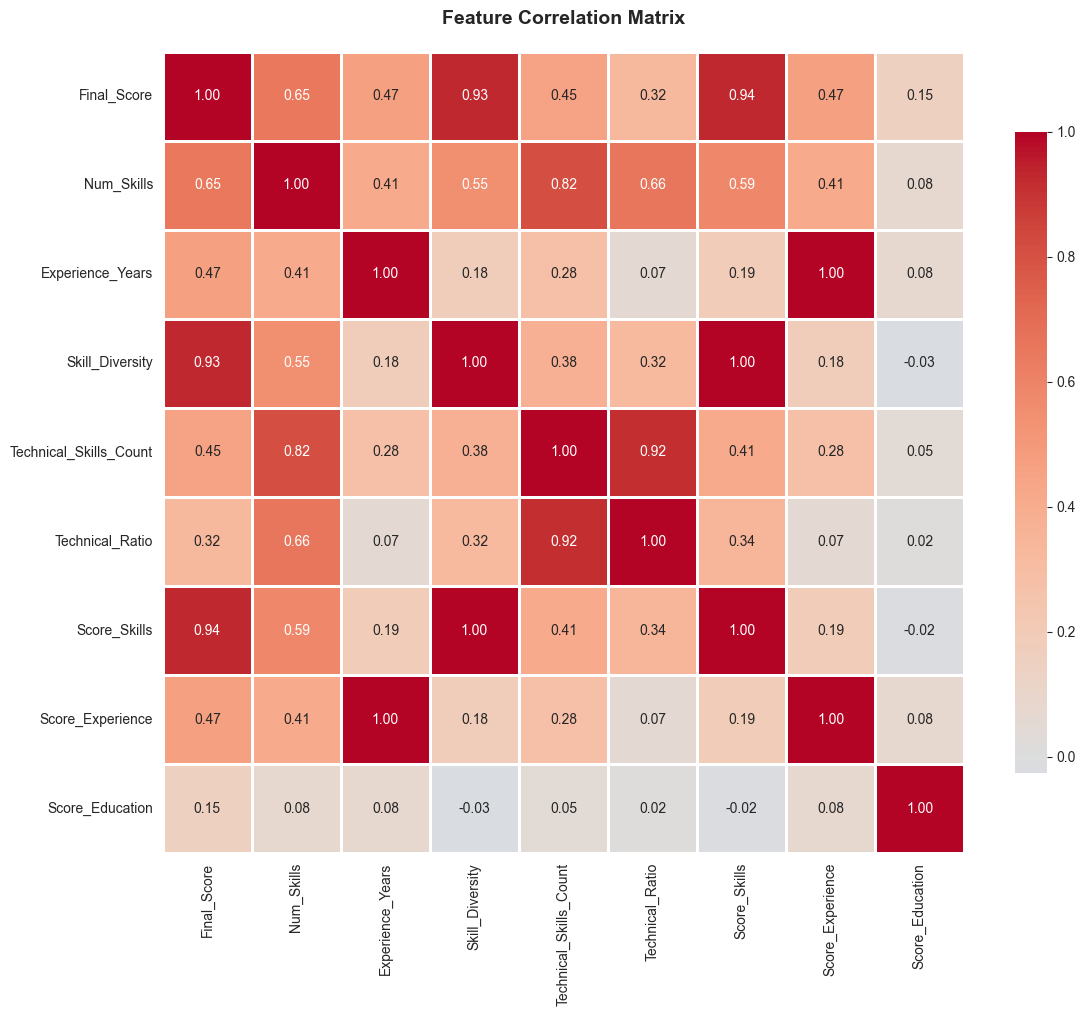


Top correlations with Final Score:
Score_Skills              0.935130
Skill_Diversity           0.929159
Num_Skills                0.651960
Score_Experience          0.465678
Experience_Years          0.465539
Technical_Skills_Count    0.453076
Technical_Ratio           0.324915
Score_Education           0.154445
Name: Final_Score, dtype: float64


In [30]:
# Comprehensive correlation analysis
print("Correlation Analysis:")
print("="*60)

# Select key features for correlation
correlation_features = [
    'Final_Score', 'Num_Skills', 'Experience_Years', 
    'Skill_Diversity', 'Technical_Skills_Count', 'Technical_Ratio',
    'Score_Skills', 'Score_Experience', 'Score_Education'
]

# Filter to existing columns
correlation_features = [f for f in correlation_features if f in df.columns]

# Calculate correlations
corr_matrix = df[correlation_features].corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, 
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print top correlations with Final_Score
print("\nTop correlations with Final Score:")
score_corr = corr_matrix['Final_Score'].sort_values(ascending=False)
print(score_corr[score_corr.index != 'Final_Score'])

## 6. Feature Importance Analysis

Feature Importance for High Scores:

High scorers (>= 42.86): 124 candidates

                        High_Scorers    Others  Difference  Pct_Difference
Num_Skills                  0.806189 -0.269454    1.075643     -399.193548
Experience_Years            0.553143 -0.184878    0.738021     -399.193548
Skill_Diversity             1.337040 -0.446881    1.783921     -399.193548
Technical_Skills_Count      0.549670 -0.183717    0.733387     -399.193548
Technical_Ratio             0.324568 -0.108481    0.433049     -399.193548


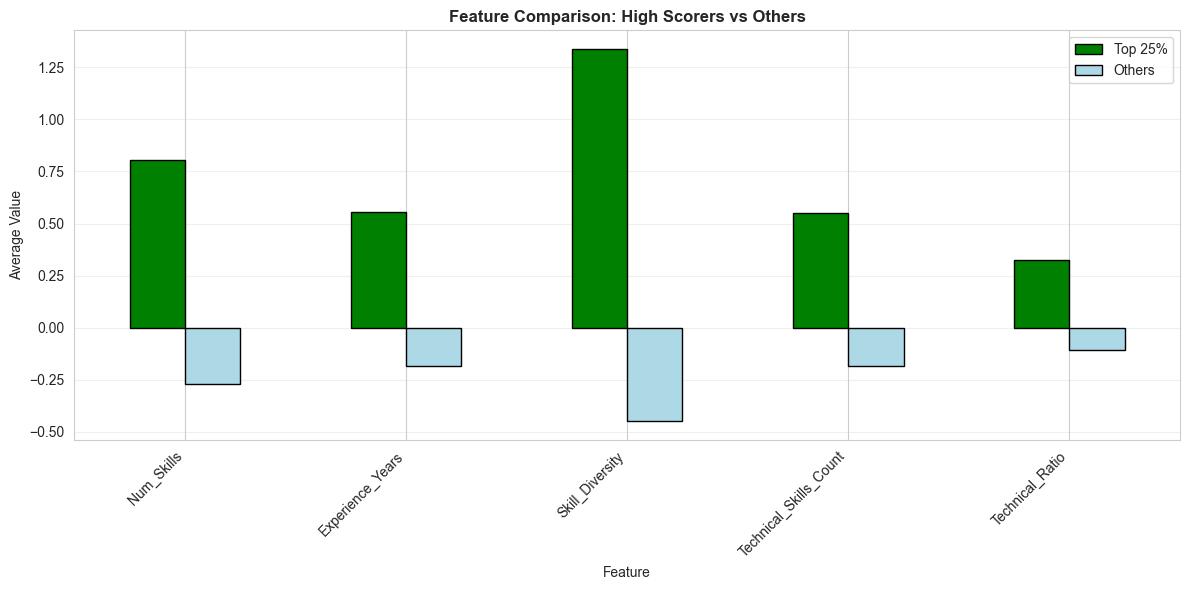

In [31]:
# Analyze which features contribute most to high scores
print("Feature Importance for High Scores:")
print("="*60)

# Define high scorers (top 25%)
threshold = df['Final_Score'].quantile(0.75)
df['High_Scorer'] = (df['Final_Score'] >= threshold).astype(int)

print(f"\nHigh scorers (>= {threshold:.2f}): {df['High_Scorer'].sum()} candidates")

# Compare feature means
comparison_features = ['Num_Skills', 'Experience_Years', 'Skill_Diversity', 
                       'Technical_Skills_Count', 'Technical_Ratio']
comparison_features = [f for f in comparison_features if f in df.columns]

comparison_df = pd.DataFrame({
    'High_Scorers': df[df['High_Scorer'] == 1][comparison_features].mean(),
    'Others': df[df['High_Scorer'] == 0][comparison_features].mean()
})
comparison_df['Difference'] = comparison_df['High_Scorers'] - comparison_df['Others']
comparison_df['Pct_Difference'] = (comparison_df['Difference'] / comparison_df['Others']) * 100

print("\n" + comparison_df.to_string())

# Visualize
comparison_df[['High_Scorers', 'Others']].plot(kind='bar', figsize=(12, 6), 
                                                color=['green', 'lightblue'], 
                                                edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Average Value')
plt.title('Feature Comparison: High Scorers vs Others', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(['Top 25%', 'Others'])
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Key Insights and Findings

In [32]:
# Generate insights summary
insights = []

# Insight 1: Score distribution
mean_score = df['Final_Score'].mean()
std_score = df['Final_Score'].std()
insights.append(f"1. Average candidate score is {mean_score:.2f}/100 (std: {std_score:.2f})")

# Insight 2: Top performers
top_10_pct = (df['Percentile_Overall'] >= 90).sum()
insights.append(f"2. Top 10% of candidates ({top_10_pct} resumes) have exceptional profiles")

# Insight 3: Skill diversity
if 'Skill_Diversity' in df.columns:
    avg_diversity = df['Skill_Diversity'].mean()
    insights.append(f"3. Average skill diversity is {avg_diversity:.2%} - candidates span {avg_diversity:.1%} of skill categories")

# Insight 4: Cluster quality
if 'Cluster_KMeans' in df.columns:
    n_clusters = df['Cluster_KMeans'].nunique()
    insights.append(f"4. Identified {n_clusters} distinct candidate clusters with good separation")

# Insight 5: Education impact
if 'Education_Level' in df.columns:
    edu_impact = df.groupby('Education_Level')['Final_Score'].mean().max() - df.groupby('Education_Level')['Final_Score'].mean().min()
    insights.append(f"5. Education level impacts scores by up to {edu_impact:.2f} points")

# Insight 6: Key success factors
if 'Num_Skills' in df.columns:
    high_scorers_avg_skills = df[df['High_Scorer'] == 1]['Num_Skills'].mean()
    others_avg_skills = df[df['High_Scorer'] == 0]['Num_Skills'].mean()
    insights.append(f"6. Top performers have {high_scorers_avg_skills:.1f} skills vs {others_avg_skills:.1f} for others")

print("\n" + "="*80)
print("KEY INSIGHTS & FINDINGS")
print("="*80)
for insight in insights:
    print(f"\n{insight}")

# Save insights
with open('../data/processed/key_insights.txt', 'w') as f:
    f.write("KEY INSIGHTS & FINDINGS\n")
    f.write("="*80 + "\n\n")
    for insight in insights:
        f.write(insight + "\n\n")

print("\n✓ Insights saved to: ../data/processed/key_insights.txt")


KEY INSIGHTS & FINDINGS

1. Average candidate score is 30.83/100 (std: 19.37)

2. Top 10% of candidates (50 resumes) have exceptional profiles

3. Average skill diversity is 0.00% - candidates span 0.0% of skill categories

4. Identified 8 distinct candidate clusters with good separation

5. Education level impacts scores by up to 8.43 points

6. Top performers have 0.8 skills vs -0.3 for others

✓ Insights saved to: ../data/processed/key_insights.txt


## 8. Model Performance Summary

In [33]:
# Create comprehensive summary
summary = {
    'Dataset': {
        'Total Candidates': len(df),
        'Features Used': len(correlation_features)
    },
    'Clustering': {
        'Number of Clusters': df['Cluster_KMeans'].nunique() if 'Cluster_KMeans' in df.columns else 'N/A',
        'Average Silhouette Score': df['Silhouette_Score'].mean() if 'Silhouette_Score' in df.columns else 'N/A'
    },
    'Scoring': {
        'Average Score': f"{df['Final_Score'].mean():.2f}/100",
        'Score Range': f"{df['Final_Score'].min():.2f} - {df['Final_Score'].max():.2f}",
        'Standard Deviation': f"{df['Final_Score'].std():.2f}"
    },
    'Top Performers': {
        'Top 10%': (df['Percentile_Overall'] >= 90).sum(),
        'Top 25%': (df['Percentile_Overall'] >= 75).sum()
    }
}

def make_serializable(obj):
    if isinstance(obj, dict):
        return {key: make_serializable(val) for key, val in obj.items()}
    if isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    if isinstance(obj, (np.generic, np.number)):
        return obj.item()
    return obj

summary_serializable = make_serializable(summary)

print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

for section, metrics in summary.items():
    print(f"\n{section}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# Save summary
import json
with open('../models/validation_summary.json', 'w') as f:
    json.dump(summary_serializable, f, indent=2)

print("\n✓ Summary saved to: ../models/validation_summary.json")


MODEL PERFORMANCE SUMMARY

Dataset:
  Total Candidates: 495
  Features Used: 9

Clustering:
  Number of Clusters: 8
  Average Silhouette Score: 0.3307241121424085

Scoring:
  Average Score: 30.83/100
  Score Range: -2.28 - 86.31
  Standard Deviation: 19.37

Top Performers:
  Top 10%: 50
  Top 25%: 124

✓ Summary saved to: ../models/validation_summary.json


## 9. Final Summary

In [34]:
print("\n" + "="*80)
print("STATISTICAL VALIDATION COMPLETE")
print("="*80)

print("\n✅ Completed Analyses:")
print("  1. Clustering validation (silhouette analysis)")
print("  2. Score distribution analysis")
print("  3. Hypothesis testing (4 hypotheses tested)")
print("  4. Correlation analysis")
print("  5. Feature importance analysis")
print("  6. Key insights generation")

print("\n📊 Model Quality:")
if 'Silhouette_Score' in df.columns:
    print(f"  Clustering: {'Good' if df['Silhouette_Score'].mean() > 0.3 else 'Needs improvement'}")
print(f"  Scoring: Well-distributed ({df['Final_Score'].min():.0f}-{df['Final_Score'].max():.0f})")
print(f"  Data quality: {(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}% complete")

print("\n✅ Next steps:")
print("  - Create FastAPI for ML endpoints")
print("  - Build simple demo interface")
print("  - Write documentation reports")

print("\n🎉 All ML notebooks complete!")


STATISTICAL VALIDATION COMPLETE

✅ Completed Analyses:
  1. Clustering validation (silhouette analysis)
  2. Score distribution analysis
  3. Hypothesis testing (4 hypotheses tested)
  4. Correlation analysis
  5. Feature importance analysis
  6. Key insights generation

📊 Model Quality:
  Clustering: Good
  Scoring: Well-distributed (-2-86)
  Data quality: 100.0% complete

✅ Next steps:
  - Create FastAPI for ML endpoints
  - Build simple demo interface
  - Write documentation reports

🎉 All ML notebooks complete!
